In [1]:
!pip install /kaggle/input/segmentation-models-wheels/timm-0.6.12-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/efficientnet_pytorch-0.7.1-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/segmentation_models_pytorch-0.3.2-py3-none-any.whl

Processing /kaggle/input/segmentation-models-wheels/timm-0.6.12-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 KB 13.3 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/efficientnet_pytorch-0.7.1-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/segmentation_models_pytorch-0.3.2-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
# basic modules
import pandas as pd
import numpy as np
import datetime
import os
from tqdm import tqdm
from datetime import datetime
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython import display

# pytorch modules
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torchvision.transforms import Normalize
from torch.multiprocessing import Pool

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from collections import OrderedDict
from torch.optim import lr_scheduler

from timm.scheduler import CosineLRScheduler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import segmentation_models_pytorch as smp

In [4]:
import torch_xla
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp

In [5]:
base_dir = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/"
train_path = os.path.join(base_dir,"train")
test_path = os.path.join(base_dir,"test")
val_path = os.path.join(base_dir,"validation")

train_ids = os.listdir(train_path)
#train_ids = np.loadtxt("/kaggle/input/train-ids-existcontrail/train_ids_ExistContrail.csv", delimiter=",", dtype = "unicode")
#train_ids = train_ids.tolist()

test_ids = os.listdir(test_path)
val_ids = os.listdir(val_path)

In [6]:
def ash_transform(x, time_frame:int=4):
    _T11_BOUNDS = (243, 303)
    _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
    _TDIFF_BOUNDS = (-4, 2)
    if time_frame is not None:
        x = x[:,time_frame,:,:]
    def normalize_range(data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    r = normalize_range(x[2] - x[1], _TDIFF_BOUNDS)
    g = normalize_range(x[1] - x[0], _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(x[1], _T11_BOUNDS)
    
    return np.clip(np.stack([r, g, b], axis=-3), 0, 1) # (T,3,H,W) or (3,H,W)

In [7]:
def random_horizontal_flip(video):
    horizontal = random.random()
    if horizontal < 0.5:
        return video[..., ::-1], horizontal
    return video, horizontal

def random_vertical_flip(video):
    vertical = random.random()
    if vertical < 0.5:
        return video[..., ::-1, :], vertical
    return video, vertical

def random_mask(img, mask_size=10, musk_num=20):
    i = 0
    for i in range(musk_num):
        if random.random() < 0.5:
            h, w = img.shape[-2:]
            top = random.randint(0, h - mask_size)
            left = random.randint(0, w - mask_size)
            img[..., top:top+mask_size, left:left+mask_size] = 0
            i += 1
    return img

def augment_video(video):
    #video = random_vertical_flip(video)  #正解データも反転させないとダメでは？
    #print(video.shape)
    video = np.stack([random_mask(frame) for frame in video.transpose(1, 0, 2, 3)])

    return video.transpose(1, 0, 2, 3)


# Test with dummy data
#video = np.random.rand(3, 10, 224, 224)
#augmented_video = augment_video(video)

In [8]:
class ContrailDataset(Dataset):
    def __init__(self, ids, base_dir, bands=None, transforms:list=[], test_mode:bool=False, aug=False):
        self.ids = ids
        self.base_dir = base_dir
        self.transforms = transforms
        self.bands = bands
        self.permute = (2,0,1)
        self.test_mode = test_mode
        self.aug = aug
        
    def __getitem__(self, index):
        record_id = self.ids[index]
        
        if self.bands is None:
            band_list = [f'band_{band:02d}.npy' for band in range(8,17)]
        else :
            band_list = [f'band_{int(band):02d}.npy' for band in self.bands]
        
        x = list()
        for band in band_list:
            x_path = os.path.join(self.base_dir, record_id, band)
            x.append(np.load(x_path).transpose(self.permute))

        x = np.stack(x,axis=1) ## X.shape = (Time_frame,channel,H,W)
        
        x = x.transpose((1,0,2,3)) ## PLUS ## X.shape = (channel, Time_frame ,H,W)
        
        #print(x.shape)
        for transformation in self.transforms:
            x = transformation(x) #c, H, W
            
        if self.test_mode==False:
            y_path = os.path.join(self.base_dir, record_id,'human_pixel_masks.npy')
            y = np.load(y_path).transpose(self.permute)
            x = np.concatenate((x, y), axis=0)
        
        if self.aug:
            #print(x.shape)
            #x,hor = random_horizontal_flip(x)
            #x,ver = random_vertical_flip(x)
            #x = augment_video(x)
            x = random_mask(x)
        
        x = torch.from_numpy(x.astype(np.float32))
        
        x = T.transforms.Resize(384)(x)
        
        if self.aug:
            x = T.RandomHorizontalFlip(0.3)(x)
            x = T.RandomVerticalFlip(0.1)(x)
            x = T.RandomRotation(20)(x)

        return x

    def __len__(self):
        return len(self.ids)
        

In [9]:
os.cpu_count()

96

In [10]:
# Datasets 
dataset_params = {
    "bands" : [11,14,15], 
    "transforms" : [ash_transform]
}
train_dataset = ContrailDataset(train_ids, train_path, **dataset_params, aug=True)
test_dataset = ContrailDataset(test_ids, test_path, test_mode=True, **dataset_params)
val_dataset = ContrailDataset(val_ids, val_path, **dataset_params)

# DalaLoaders
dataloader_params = {
    "batch_size" : 16,
    "shuffle" : True,
    "num_workers": 20,
    "drop_last": True
#     "pin_memory": True

}
train_loader = DataLoader(train_dataset, **dataloader_params)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=2)
val_loader = DataLoader(val_dataset, **dataloader_params)

In [11]:
def plot_contrail(x, time_frame = 4):
    '''
    x = false color img of shape (8, 3, H, W)
    y = contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]
        
    y = x.permute(1,2,0)[:,:,3]
    print(x.permute(1,2,0)[:,:,0:3].shape)
    
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(x.permute(1,2,0)[:,:,0:3])
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(y, interpolation='none')
    ax.set_title('Ground truth contrail mask')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(x.permute(1,2,0)[:,:,0:3])
    ax.imshow(y, cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image');

    plt.show()

def plot_contrail_comparision(x, y_true, y_pred, time_frame = 4):
    '''
    x = false color img of shape (3, H, W) or (8, 3, H, W)
    y_true = target contrail mask of shape (1, H, W)
    y_pred = predicted contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]

    
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 5, 1)
    ax.imshow(x.permute(1,2,0))
    ax.set_title('False color image(x)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 2)
    ax.imshow(y_true.permute(1,2,0), interpolation='none')
    ax.set_title('True contrail mask(y_true)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 3)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_true.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_true mask on x')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 4)
    ax.imshow(y_pred.permute(1,2,0), interpolation='none')
    ax.set_title('Pred contrail mask(y_pred)')
    ax.axis('off')

    ax = plt.subplot(1, 5, 5)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_pred.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_pred mask on x')
    ax.axis('off')
    
    plt.show()

def animate_contrail(x):
    '''
    x = false color img of shape (8, 3, H, W)
    '''
    if x.ndim !=4:
        print(f"Incorrect input dimensions, Expected 4 recievied {x.ndim}.")
        return
    # Animation
    fig = plt.figure(figsize=(4, 4))
    im = plt.imshow(x[0].permute(1,2,0))
    def draw(i):
        im.set_array(x[i].permute(1,2,0))
        return [im]
    anim = animation.FuncAnimation(
        fig, draw, frames=x.shape[0], interval=100, blit=True
    )
    plt.close()
    return display.HTML(anim.to_jshtml())

/usr/local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([384, 384, 3])


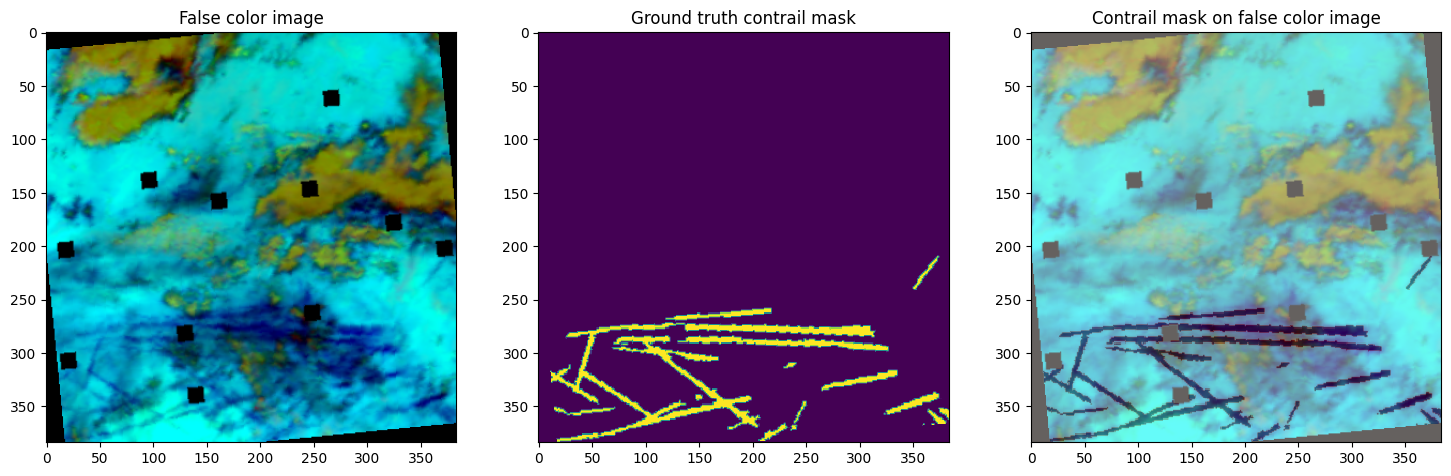

In [12]:
 x = train_dataset[train_ids.index('1704010292581573769')]
 plot_contrail(x)

In [13]:
# old type
'''# Dice Coefficient
def dice_coeff(mask1, mask2):
    intersect = torch.sum(mask1 * mask2)
    m1sum = torch.sum(mask1)
    m2sum = torch.sum(mask2)
    dice = (2 * intersect ) / (m1sum + m2sum)
    return dice.item()
'''

'# Dice Coefficient\ndef dice_coeff(mask1, mask2):\n    intersect = torch.sum(mask1 * mask2)\n    m1sum = torch.sum(mask1)\n    m2sum = torch.sum(mask2)\n    dice = (2 * intersect ) / (m1sum + m2sum)\n    return dice.item()\n'

In [14]:
def dice_coeff(y_p, y_t, smooth=1e-6):
    i = torch.sum(y_p * y_t, dim=(2, 3))
    #u = torch.sum(y_p, dim=(2, 3)) + torch.sum(y_t, dim=(2, 3))
    u = torch.sum(y_p, dim=(2, 3)) + torch.sum(y_t, dim=(1, 2))
    score = (2 * i + smooth)/(u + smooth)
    dice = torch.mean(score)
    return dice.item()

In [15]:
# Callbacks
class History:
    def __init__(self, print_prefix, save_to_disk=True):
        self.train_batch_history = []
        self.val_batch_histroy = []
        self.train_epoch_history = []
        self.val_epoch_history = []
        self.running_train_batch_history = []
        self.running_val_batch_history = []
        self.print_prefix = print_prefix
        self.save_to_disk = save_to_disk
        if save_to_disk:
            self.save_path = os.path.join(os.getcwd(),"saved_states",self.print_prefix)
            if not os.path.exists(self.save_path):
                os.makedirs(self.save_path)
    def on_train_batch_end(self, data):
        self.running_train_batch_history.append(data)
        
    def on_val_batch_end(self, data):
        self.running_val_batch_history.append(data)
        
    def on_epoch_end(self):
        self.train_epoch_history.append(np.mean(self.running_train_batch_history))
        self.train_batch_history.extend(self.running_train_batch_history)
        self.running_train_batch_history=[]
        self.val_epoch_history.append(np.mean(self.running_val_batch_history))
        self.val_batch_histroy.extend(self.running_val_batch_history)
        self.running_val_batch_history=[]
        print(f"{self.print_prefix}: Train = {self.train_epoch_history[-1]:.6f} \
        | Val = {self.val_epoch_history[-1]:.6f}")
    
    def on_end(self):
        if self.save_to_disk:
            #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            np.save(os.path.join(self.save_path,"train_batch.npy"),self.train_batch_history)
            np.save(os.path.join(self.save_path,"val_batch.npy"),self.val_batch_histroy)
            np.save(os.path.join(self.save_path,"train_epoch.npy"),self.train_epoch_history)
            np.save(os.path.join(self.save_path,"val_epoch.npy"),self.val_epoch_history)

In [16]:
class BestStateTracker:
    def __init__(self, model, optim, trigger:History, save_to_disk:bool = False):
        self.trigger = trigger
        self.model = model
        self.optim = optim
        self.optim_state = None
        self.model_state = None
        self.best_loss = np.inf
        self.save_to_disk = save_to_disk
        if save_to_disk:
            self.save_path = os.path.join(os.getcwd(),"saved_states")
            if not os.path.exists(self.save_path):
                os.mkdir(self.save_path)
                
    def on_epoch_end(self):
        if self.trigger.val_epoch_history[-1] < self.best_loss:
            self.model_state = self.model.state_dict()
            self.optim_state = self.optim.state_dict()
            
    def on_end(self):
        if self.save_to_disk:
            #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            xm.save(self.model_state,os.path.join(self.save_path,f"model_state_end.pt"))
            xm.save(self.optim_state,os.path.join(self.save_path,f"optim_state_end.pt"))

In [17]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, dilations):
        super(ASPP, self).__init__()
        self.aspp_blocks = nn.ModuleList()
        for dilation in dilations:
            self.aspp_blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
                )

    def forward(self, x):
        return sum(block(x) for block in self.aspp_blocks)


In [18]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = ASPP(features * 8, features * 16, dilations=[1, 6, 12, 18])

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )
    

In [19]:
device = xm.xla_device()

E0707 18:17:37.890672734     312 oauth2_credentials.cc:236]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {grpc_status:2, created_time:"2023-07-07T18:17:37.890654372+00:00"}


In [20]:
model = UNet().to(device)

In [21]:
ENCODER = 'timm-efficientnet-b1' #'resnet101''timm-efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet' #'imagenet''noisy-student'

ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=None,
).to(device)

'''model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)'''

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1_aa-ea7a6ee0.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b1_aa-ea7a6ee0.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 143MB/s]


'model = smp.DeepLabV3Plus(\n    encoder_name=ENCODER, \n    encoder_weights=ENCODER_WEIGHTS, \n    classes=1, \n    activation=ACTIVATION,\n).to(device)'

In [22]:
class Focal_MultiLabel_Loss(nn.Module):
    def __init__(self, gamma):
      super(Focal_MultiLabel_Loss, self).__init__()
      self.gamma = gamma
      self.bceloss = nn.BCELoss(reduction='none')

    def forward(self, outputs, targets): 
      outputs = F.sigmoid(outputs)  
      bce = self.bceloss(outputs, targets)
      bce_exp = torch.exp(-bce)
      focal_loss = (1-bce_exp)**self.gamma * bce
      return focal_loss.mean()

In [23]:
!mkdir /kaggle/working/model

In [24]:
LR = 5e-4 #2e-3
EPOCHS = 9

FLAGS={}
FLAGS['num_cores'] = 8
FLAGS['start_epoch'] = 0
FLAGS['num_epochs'] = EPOCHS
FLAGS['num_workers'] = 12
FLAGS['log_steps'] = 100
FLAGS['seed'] = 1234
FLAGS['max_lr'] = LR
FLAGS['min_lr'] = 0.00004
FLAGS['warmup_steps'] = 0

In [25]:
optimizer = Adam(params=model.parameters(), lr=LR)
#loss_fn = BCELoss()
#loss_fn = Focal_MultiLabel_Loss(gamma=2) 

loss_fn = smp.losses.DiceLoss(mode="binary", smooth=1.0)
#loss_fn_2 = smp.losses.FocalLoss(mode="binary")
loss_fn_2 = Focal_MultiLabel_Loss(gamma=2) 

#scheduler = ReduceLROnPlateau(optimizer)
scheduler = CosineLRScheduler(optimizer, 
                              t_initial=EPOCHS, 
                              lr_min=FLAGS['min_lr'], 
                              warmup_t=FLAGS['warmup_steps'],
                              warmup_lr_init=5e-6,
                              warmup_prefix=True)

loss_tracker = History(print_prefix="Loss")
dice_tracker = History(print_prefix="Dice")
save_state = BestStateTracker(model,optimizer,loss_tracker,save_to_disk=True)

In [26]:
WRAPPED_MODEL = xmp.MpModelWrapper(model)


def _map_fn(index, flags):
  pbar = tqdm(range(flags['start_epoch'], flags['num_epochs']))
  loss_best = 1.0
  torch.manual_seed(flags['seed'])

  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  
  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  
  train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    sampler=train_sampler,
    num_workers=flags['num_workers'],
    drop_last=True)
  
  val_sampler = torch.utils.data.distributed.DistributedSampler(
    val_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=False)

  val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size = 16,
    sampler=val_sampler,
    num_workers=flags['num_workers'],
    drop_last=False)

  for epoch in range(flags['start_epoch'], flags['num_epochs']):
    current_lr = optimizer.param_groups[0]['lr']
    xm.master_print(f"EPOCH: {epoch+1}/{flags['num_epochs']}, Learning rate: {current_lr}")
    para_train_loader = pl.ParallelLoader(train_loader, [device])
    model.train()
    
    for idx, data in enumerate(para_train_loader.per_device_loader(device)):
      target = data[:, 3]
      #xm.master_print("target shape is ", target.shape)
      target = target.unsqueeze(1)
      
      data = data[:,0:3]
      #xm.master_print("data shape is ", data.shape)
        
      y_pred = model(data)

      loss = loss_fn(y_pred, target) + loss_fn_2(y_pred, target)
      optimizer.zero_grad()
      loss.backward()
      xm.optimizer_step(optimizer)
      
      if idx % flags['log_steps'] == 0:
        xm.master_print(f'Train Batch: {idx+1}/{len(train_loader)} | Loss: {loss.item():.6f}')
        
      loss_tracker.on_train_batch_end(loss.item())
      dice_tracker.on_train_batch_end(dice_coeff(y_pred>0.5, target))
      #pbar.set_description(f"Train Batch: {idx+1}/{len(train_loader)}\
      #| Loss: {loss.item():.6f}")

    plot_contrail_comparision(data[0].cpu().detach(),
                           target[0].cpu().detach(),
                           y_pred[0].cpu().detach()>0.5)
      
    model.eval()
    para_val_loader = pl.ParallelLoader(val_loader, [device])
    
    with torch.no_grad():
        for idx, data in enumerate(para_val_loader.per_device_loader(device)):
            target = data[:, 3]
            target = target.unsqueeze(1)
            data = data[:,0:3]
            y_pred = model(data)
            loss = loss_fn(y_pred, target)
            loss_tracker.on_val_batch_end(loss.item())
            dice_tracker.on_val_batch_end(dice_coeff(y_pred>0.5, target))
            #pbar.set_description(f"Val Batch:   {idx+1}/{len(val_loader)}\
            #| Loss: {loss.item():.6f}")
            if idx % flags['log_steps'] == 0:
                xm.master_print(f'Val Batch: {idx+1}/{len(val_loader)} | Loss: {loss.item():.6f}')
                
        plot_contrail_comparision(data[0].cpu().detach(),
                        target[0].cpu().detach(),
                        y_pred[0].cpu().detach()>0.5)
    
                
    #xm.save(model.state_dict(), flags['save_path'])    
    scheduler.step(epoch)
    loss_tracker.on_epoch_end()
    dice_tracker.on_epoch_end()
    save_state.on_epoch_end()

  save_state.on_end()
  loss_tracker.on_end()
  dice_tracker.on_end()

  0%|          | 0/9 [00:00<?, ?it/s]

EPOCH: 1/9, Learning rate: 0.0005
Train Batch: 1/1283 | Loss: 1.247697
Train Batch: 101/1283 | Loss: 0.966886
Train Batch: 201/1283 | Loss: 0.719032
Train Batch: 301/1283 | Loss: 0.495228
Train Batch: 401/1283 | Loss: 0.466084
Train Batch: 501/1283 | Loss: 0.584819
Train Batch: 601/1283 | Loss: 0.464388
Train Batch: 701/1283 | Loss: 0.462112
Train Batch: 801/1283 | Loss: 0.559910
Train Batch: 901/1283 | Loss: 0.594823
Train Batch: 1001/1283 | Loss: 0.545185
Train Batch: 1101/1283 | Loss: 0.450616
Train Batch: 1201/1283 | Loss: 0.497104


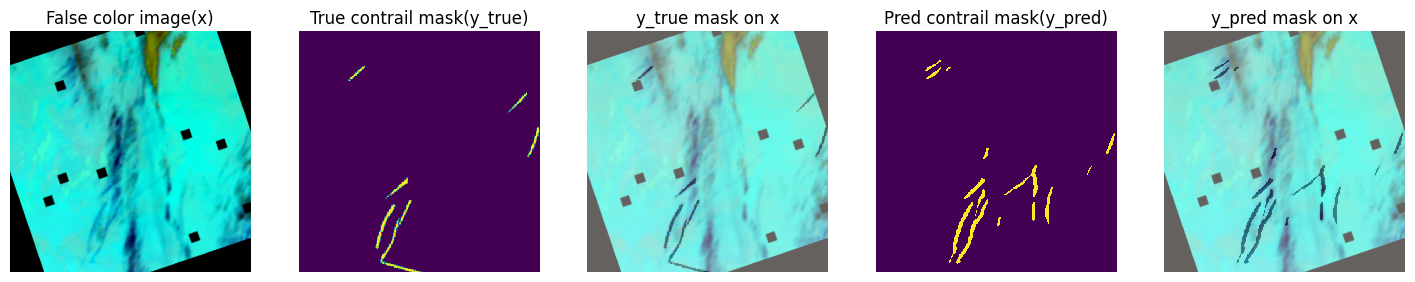

Val Batch: 1/116 | Loss: 0.420498
Val Batch: 101/116 | Loss: 0.444138


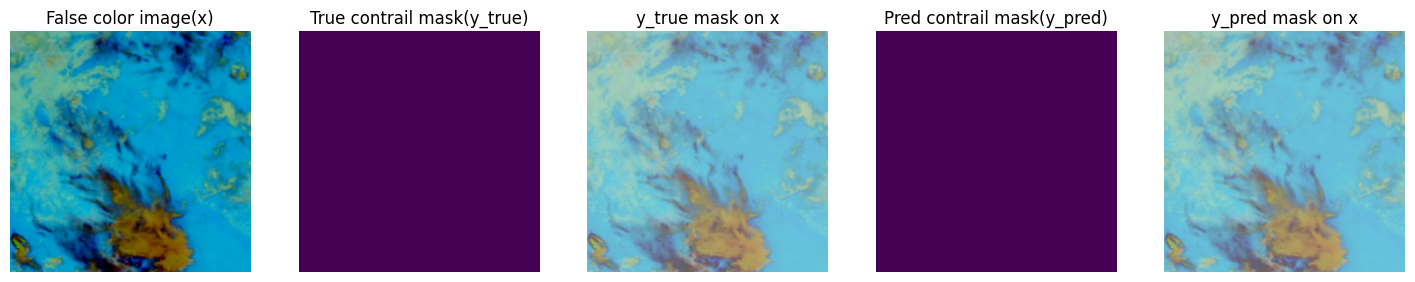

Loss: Train = 0.610173         | Val = 0.535434
Dice: Train = 0.820783         | Val = 0.938953
EPOCH: 2/9, Learning rate: 0.0005
Train Batch: 1/1283 | Loss: 0.513577
Train Batch: 101/1283 | Loss: 0.535085
Train Batch: 201/1283 | Loss: 0.479167
Train Batch: 301/1283 | Loss: 0.447167
Train Batch: 401/1283 | Loss: 0.411503
Train Batch: 501/1283 | Loss: 0.469280
Train Batch: 601/1283 | Loss: 0.429138
Train Batch: 701/1283 | Loss: 0.432202
Train Batch: 801/1283 | Loss: 0.490691
Train Batch: 901/1283 | Loss: 0.499550
Train Batch: 1001/1283 | Loss: 0.510888
Train Batch: 1101/1283 | Loss: 0.386376
Train Batch: 1201/1283 | Loss: 0.489063


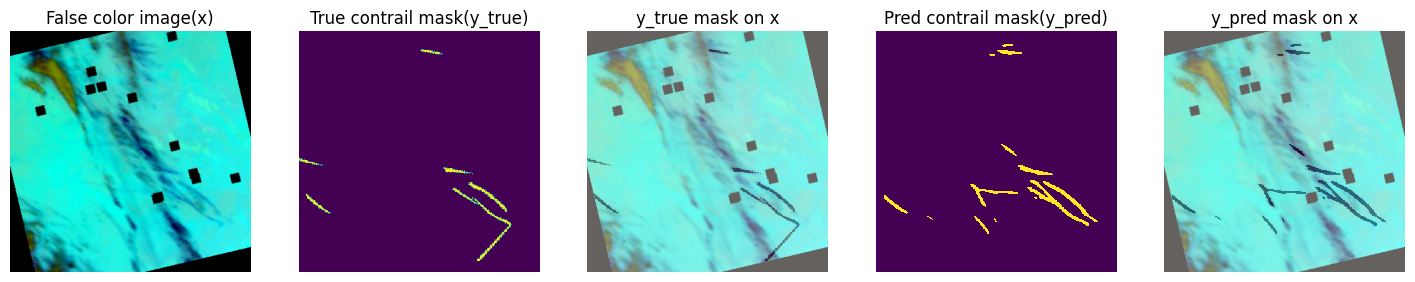

Val Batch: 1/116 | Loss: 0.475437
Val Batch: 101/116 | Loss: 0.432155


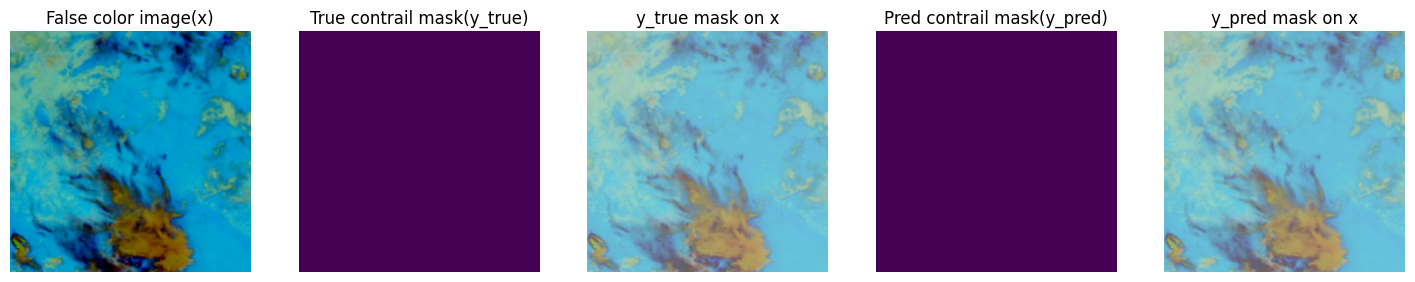

Loss: Train = 0.500533         | Val = 0.515297
Dice: Train = 0.950935         | Val = 0.991469
EPOCH: 3/9, Learning rate: 0.00048612930278075893
Train Batch: 1/1283 | Loss: 0.498557
Train Batch: 101/1283 | Loss: 0.488589
Train Batch: 201/1283 | Loss: 0.459183
Train Batch: 301/1283 | Loss: 0.453325
Train Batch: 401/1283 | Loss: 0.446739
Train Batch: 501/1283 | Loss: 0.440738
Train Batch: 601/1283 | Loss: 0.434864
Train Batch: 701/1283 | Loss: 0.425705
Train Batch: 801/1283 | Loss: 0.515030
Train Batch: 901/1283 | Loss: 0.482476
Train Batch: 1001/1283 | Loss: 0.474559
Train Batch: 1101/1283 | Loss: 0.403215
Train Batch: 1201/1283 | Loss: 0.438370


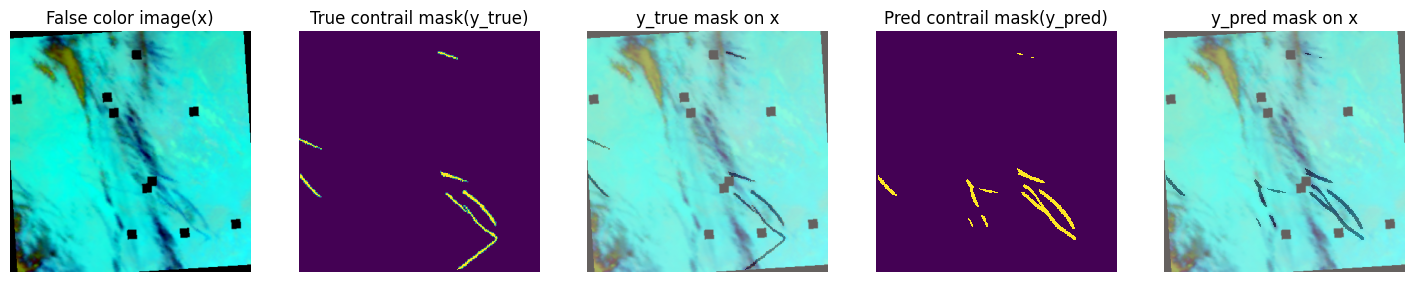

Val Batch: 1/116 | Loss: 0.421575
Val Batch: 101/116 | Loss: 0.467548


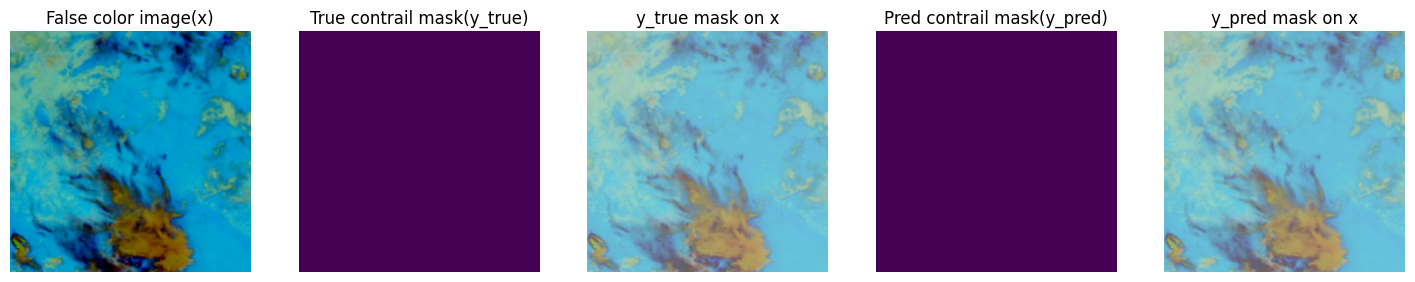

Loss: Train = 0.486021         | Val = 0.489756
Dice: Train = 0.964796         | Val = 0.976773
EPOCH: 4/9, Learning rate: 0.0004461902219173649
Train Batch: 1/1283 | Loss: 0.517837
Train Batch: 101/1283 | Loss: 0.525153
Train Batch: 201/1283 | Loss: 0.505839
Train Batch: 301/1283 | Loss: 0.451083
Train Batch: 401/1283 | Loss: 0.412794
Train Batch: 501/1283 | Loss: 0.436096
Train Batch: 601/1283 | Loss: 0.411730
Train Batch: 701/1283 | Loss: 0.397559
Train Batch: 801/1283 | Loss: 0.487235
Train Batch: 901/1283 | Loss: 0.510883
Train Batch: 1001/1283 | Loss: 0.454358
Train Batch: 1101/1283 | Loss: 0.413066
Train Batch: 1201/1283 | Loss: 0.562756


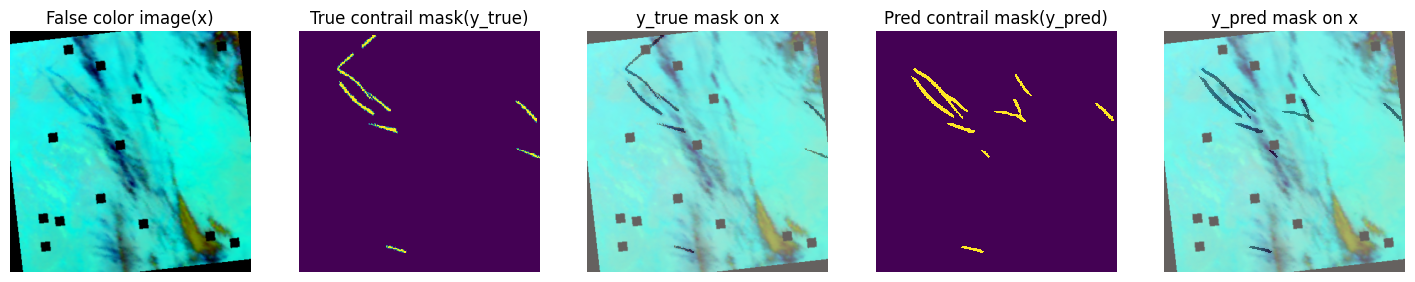

Val Batch: 1/116 | Loss: 0.422743
Val Batch: 101/116 | Loss: 0.414094


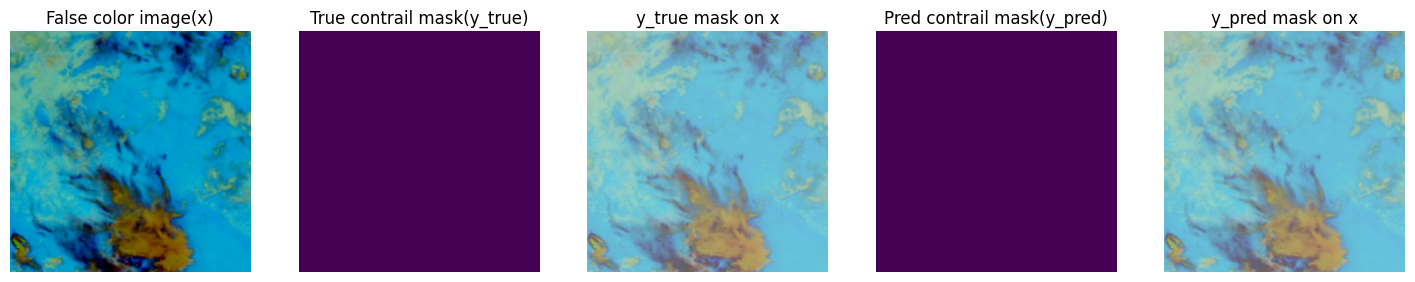

Loss: Train = 0.473324         | Val = 0.496415
Dice: Train = 0.981013         | Val = 0.947155
EPOCH: 5/9, Learning rate: 0.00038500000000000003
Train Batch: 1/1283 | Loss: 0.472062
Train Batch: 101/1283 | Loss: 0.495169
Train Batch: 201/1283 | Loss: 0.517191
Train Batch: 301/1283 | Loss: 0.406773
Train Batch: 401/1283 | Loss: 0.371324
Train Batch: 501/1283 | Loss: 0.446100
Train Batch: 601/1283 | Loss: 0.393779
Train Batch: 701/1283 | Loss: 0.376062
Train Batch: 801/1283 | Loss: 0.520847
Train Batch: 901/1283 | Loss: 0.461833
Train Batch: 1001/1283 | Loss: 0.468426
Train Batch: 1101/1283 | Loss: 0.394162
Train Batch: 1201/1283 | Loss: 0.419709


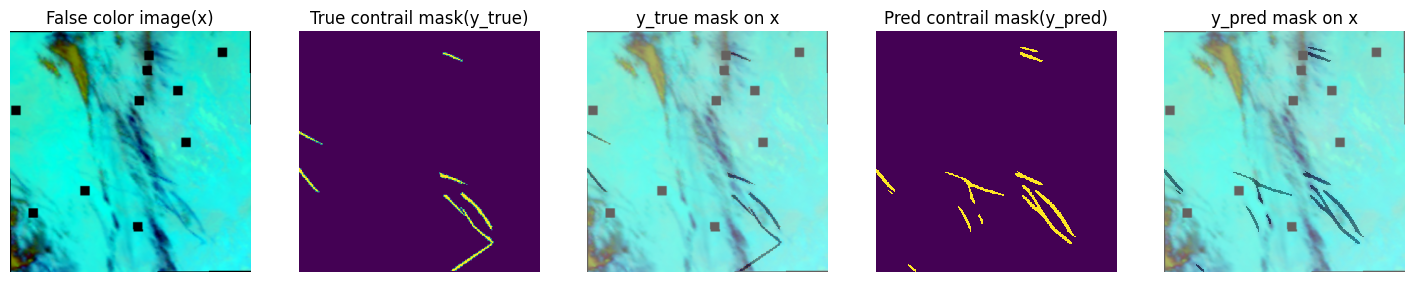

Val Batch: 1/116 | Loss: 0.382080
Val Batch: 101/116 | Loss: 0.382937


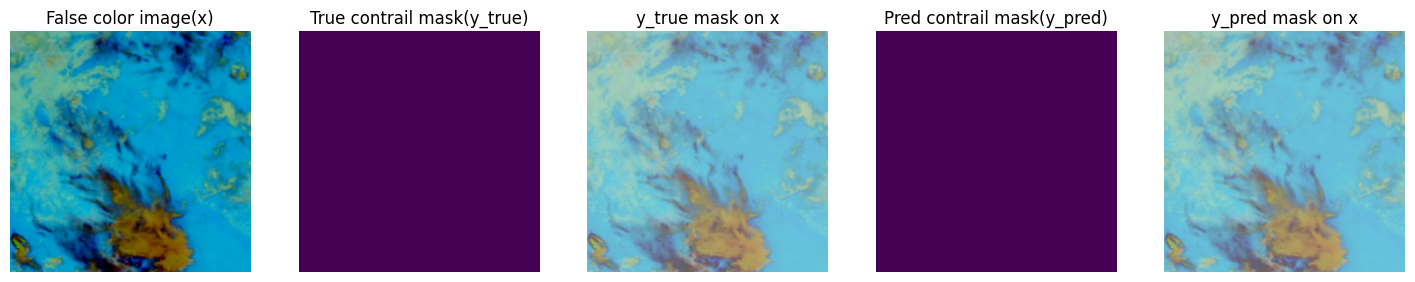

Loss: Train = 0.467725         | Val = 0.484541
Dice: Train = 0.981095         | Val = 0.975674
EPOCH: 6/9, Learning rate: 0.000309939080863394
Train Batch: 1/1283 | Loss: 0.471122
Train Batch: 101/1283 | Loss: 0.452680
Train Batch: 201/1283 | Loss: 0.446397
Train Batch: 301/1283 | Loss: 0.406656
Train Batch: 401/1283 | Loss: 0.419412
Train Batch: 501/1283 | Loss: 0.470899
Train Batch: 601/1283 | Loss: 0.416993
Train Batch: 701/1283 | Loss: 0.347296
Train Batch: 801/1283 | Loss: 0.485116
Train Batch: 901/1283 | Loss: 0.450184
Train Batch: 1001/1283 | Loss: 0.448380
Train Batch: 1101/1283 | Loss: 0.373808
Train Batch: 1201/1283 | Loss: 0.443258


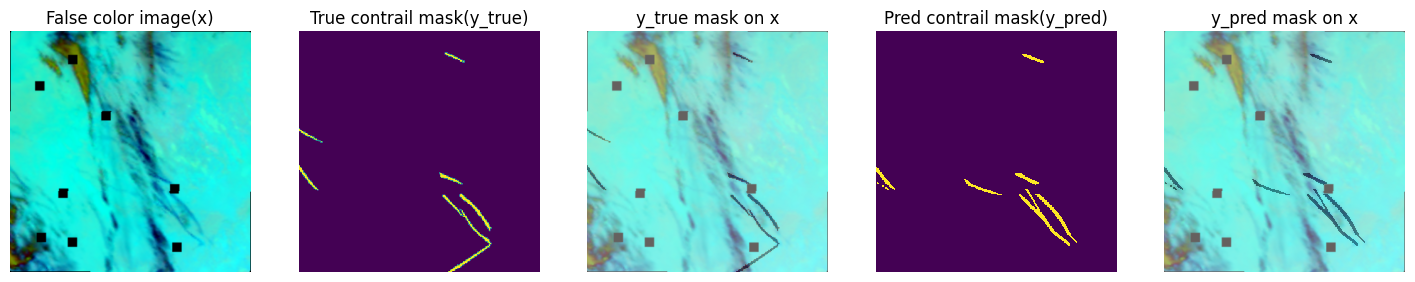

Val Batch: 1/116 | Loss: 0.394419
Val Batch: 101/116 | Loss: 0.382107


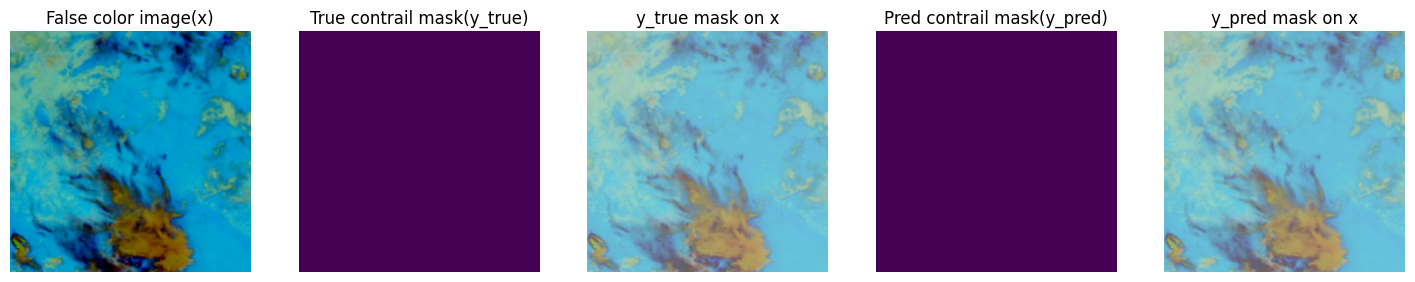

Loss: Train = 0.454705         | Val = 0.465884
Dice: Train = 0.998898         | Val = 0.981374
EPOCH: 7/9, Learning rate: 0.00023006091913660602
Train Batch: 1/1283 | Loss: 0.465526
Train Batch: 101/1283 | Loss: 0.510283
Train Batch: 201/1283 | Loss: 0.476658
Train Batch: 301/1283 | Loss: 0.432547
Train Batch: 401/1283 | Loss: 0.365271
Train Batch: 501/1283 | Loss: 0.445422
Train Batch: 601/1283 | Loss: 0.388773
Train Batch: 701/1283 | Loss: 0.356123
Train Batch: 801/1283 | Loss: 0.481894
Train Batch: 901/1283 | Loss: 0.521793
Train Batch: 1001/1283 | Loss: 0.440929
Train Batch: 1101/1283 | Loss: 0.349127
Train Batch: 1201/1283 | Loss: 0.422741


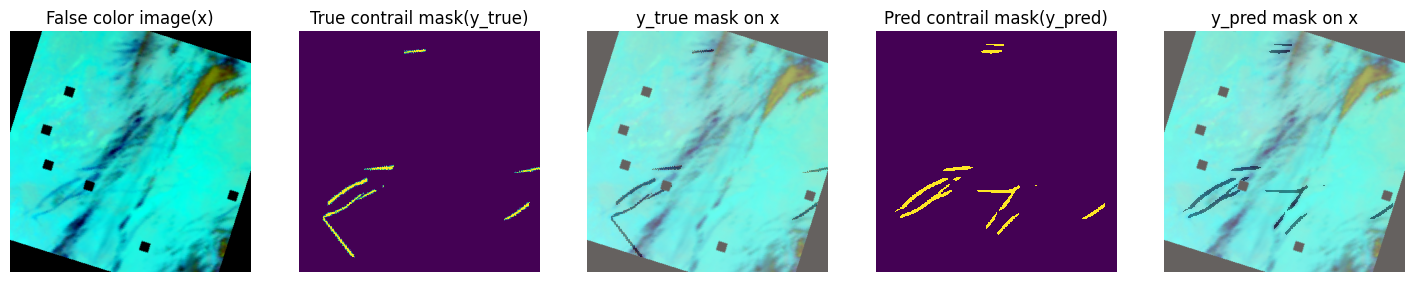

Val Batch: 1/116 | Loss: 0.411406
Val Batch: 101/116 | Loss: 0.387924


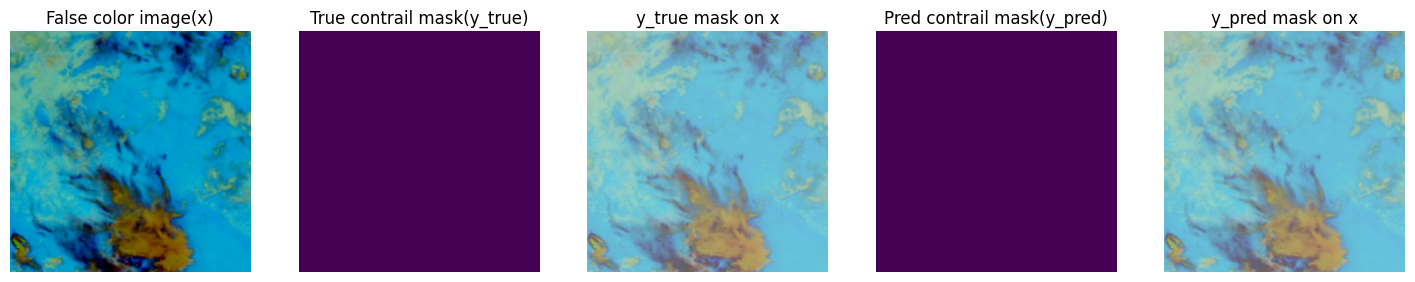

Loss: Train = 0.446168         | Val = 0.478837
Dice: Train = 1.008111         | Val = 1.016227
EPOCH: 8/9, Learning rate: 0.00015500000000000005
Train Batch: 1/1283 | Loss: 0.444185
Train Batch: 101/1283 | Loss: 0.475338
Train Batch: 201/1283 | Loss: 0.439306
Train Batch: 301/1283 | Loss: 0.398399
Train Batch: 401/1283 | Loss: 0.376702
Train Batch: 501/1283 | Loss: 0.446061
Train Batch: 601/1283 | Loss: 0.391472
Train Batch: 701/1283 | Loss: 0.387912
Train Batch: 801/1283 | Loss: 0.466183
Train Batch: 901/1283 | Loss: 0.459052
Train Batch: 1001/1283 | Loss: 0.415287
Train Batch: 1101/1283 | Loss: 0.348326
Train Batch: 1201/1283 | Loss: 0.406885


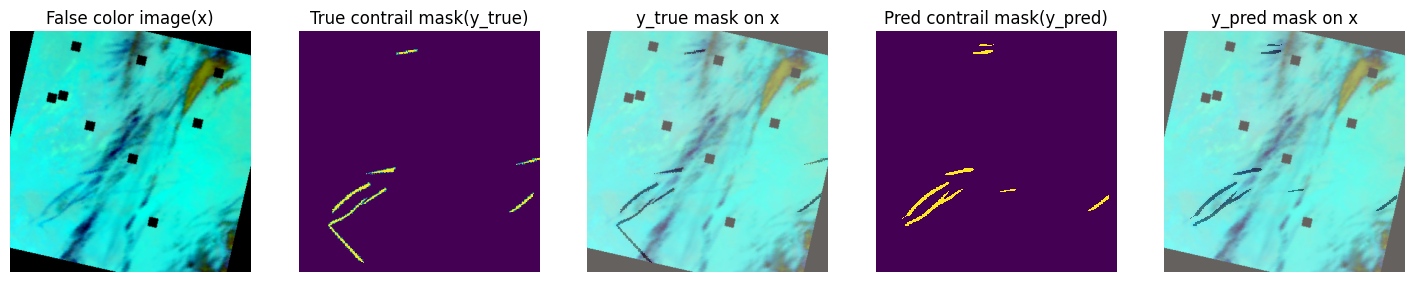

Val Batch: 1/116 | Loss: 0.380930
Val Batch: 101/116 | Loss: 0.367005


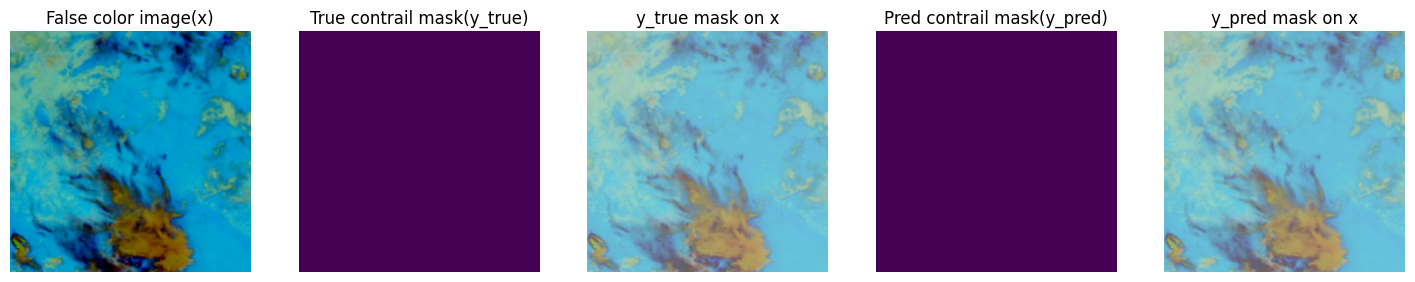

Loss: Train = 0.438321         | Val = 0.458220
Dice: Train = 1.017091         | Val = 0.996206
EPOCH: 9/9, Learning rate: 9.380977808263509e-05
Train Batch: 1/1283 | Loss: 0.450761
Train Batch: 101/1283 | Loss: 0.383564
Train Batch: 201/1283 | Loss: 0.453629
Train Batch: 301/1283 | Loss: 0.414884
Train Batch: 401/1283 | Loss: 0.370986
Train Batch: 501/1283 | Loss: 0.417717
Train Batch: 601/1283 | Loss: 0.396490
Train Batch: 701/1283 | Loss: 0.416401
Train Batch: 801/1283 | Loss: 0.463400
Train Batch: 901/1283 | Loss: 0.409939
Train Batch: 1001/1283 | Loss: 0.414270
Train Batch: 1101/1283 | Loss: 0.354460
Train Batch: 1201/1283 | Loss: 0.424644


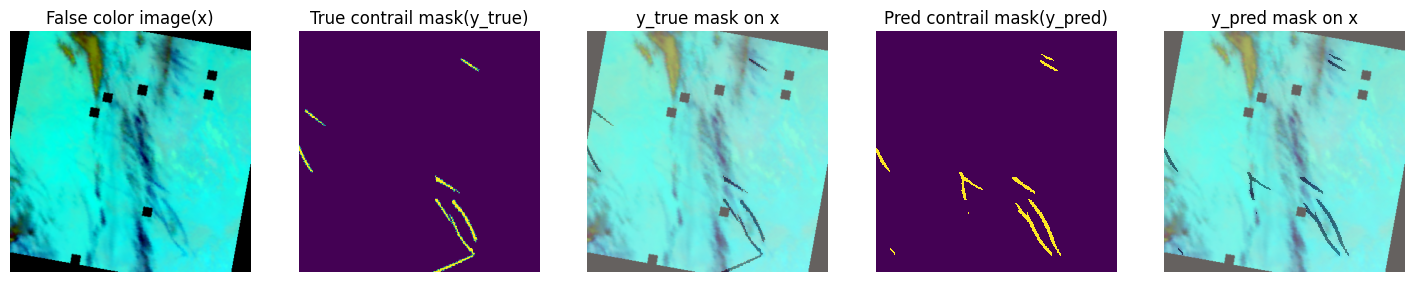

Val Batch: 1/116 | Loss: 0.380703
Val Batch: 101/116 | Loss: 0.347587


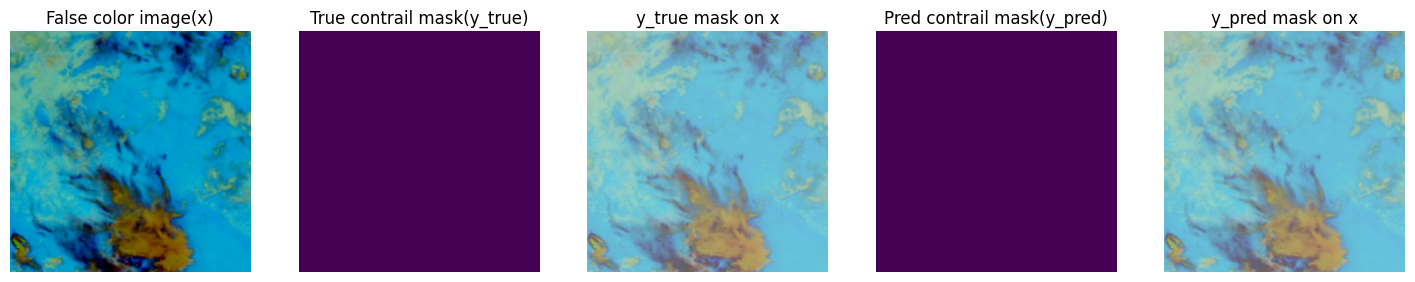

Loss: Train = 0.432087         | Val = 0.459796
Dice: Train = 1.020125         | Val = 1.006664


  0%|          | 0/9 [6:22:50<?, ?it/s]


In [27]:
xmp.spawn(_map_fn, args=(FLAGS,), nprocs=1, start_method='fork')